# How to Build Exponential Smoothing Models Using Python: Simple Exponential Smoothing, Holt, and Holt-Winters

* Ref: [https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1](https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1)
* Data: 
    * No data provided
    * I download a csv file from [https://catalog.data.gov/dataset/allegheny-county-property-sale-transactions](https://catalog.data.gov/dataset/allegheny-county-property-sale-transactions)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Allegheny_County_Property_Sale_Transactions.csv')
display(df.head())
df.info()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESSDIR,PROPERTYADDRESSSTREET,PROPERTYADDRESSSUF,PROPERTYADDRESSUNITDESC,PROPERTYUNITNO,PROPERTYCITY,PROPERTYSTATE,PROPERTYZIP,SCHOOLCODE,SCHOOLDESC,MUNICODE,MUNIDESC,RECORDDATE,SALEDATE,PRICE,DEEDBOOK,DEEDPAGE,SALECODE,SALEDESC,INSTRTYP,INSTRTYPDESC
0,1075F00108000000,4720.0,,NaN,HIGHPOINT,DR,NaN,NaN,GIBSONIA,PA,15044.0,20,Hampton Township,914,Hampton,2012-09-27,2012-09-27,120000.0,15020,356,3,LOVE AND AFFECTION SALE,DE,DEED
1,0011A00237000000,0.0,,NaN,LOMBARD,ST,NaN,NaN,PITTSBURGH,PA,15219.0,47,Pittsburgh,103,3rd Ward - PITTSBURGH,2015-01-06,2015-01-06,1783.0,TR15,2,2,CITY TREASURER SALE,TS,TREASURER DEED
2,0011J00047000000,1903.0,,NaN,FORBES,AVE,NaN,NaN,PITTSBURGH,PA,15219.0,47,Pittsburgh,101,1st Ward - PITTSBURGH,2012-10-26,2012-10-26,4643.0,TR13,3,2,CITY TREASURER SALE,TS,TREASURER DEED
3,0113B00029000000,479.0,,NaN,ROOSEVELT,AVE,NaN,NaN,PITTSBURGH,PA,15202.0,29,Northgate,803,Bellevue,2017-03-27,2017-03-06,0.0,16739,166,3,LOVE AND AFFECTION SALE,CO,CORRECTIVE DEED
4,0119S00024000000,5418.0,,NaN,CARNEGIE,ST,NaN,NaN,PITTSBURGH,PA,15201.0,47,Pittsburgh,110,10th Ward - PITTSBURGH,2015-02-04,2015-02-04,27541.0,TR15,59,GV,GOVERNMENT SALE,TS,TREASURER DEED


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289543 entries, 0 to 289542
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   PARID                    289543 non-null  object 
 1   PROPERTYHOUSENUM         289525 non-null  float64
 2   PROPERTYFRACTION         289543 non-null  object 
 3   PROPERTYADDRESSDIR       11932 non-null   object 
 4   PROPERTYADDRESSSTREET    289536 non-null  object 
 5   PROPERTYADDRESSSUF       288282 non-null  object 
 6   PROPERTYADDRESSUNITDESC  5629 non-null    object 
 7   PROPERTYUNITNO           5804 non-null    object 
 8   PROPERTYCITY             289542 non-null  object 
 9   PROPERTYSTATE            289543 non-null  object 
 10  PROPERTYZIP              289542 non-null  float64
 11  SCHOOLCODE               289543 non-null  int64  
 12  SCHOOLDESC               289543 non-null  object 
 13  MUNICODE                 289543 non-null  int64  
 14  MUNI

,PROPERTYHOUSENUM
SALEDATE,
2012-01-31,3370236.0
2012-02-29,3063270.0
2012-03-31,3584459.0
2012-04-30,3506950.0
2012-05-31,4143140.0


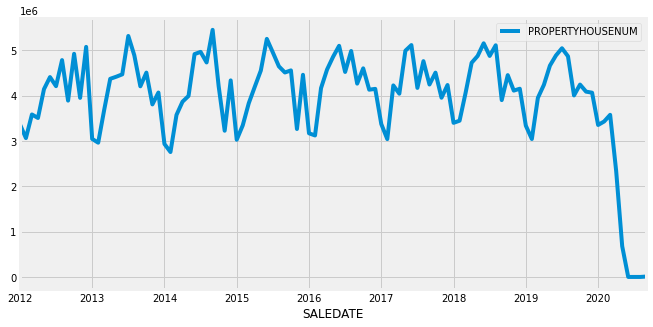

In [ ]:
df = df[['SALEDATE', 'PROPERTYHOUSENUM']]
df['SALEDATE'] = pd.to_datetime(df['SALEDATE'])
df.set_index('SALEDATE', inplace=True)
df = df.resample('M').sum()
display(df.head())

fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
plt.show()

2020 開始有一個很奇怪的 drop 所以不要用這部分的數據

## 2. Analyze
* 檢查是否有 bias
    * 1 sample student test
      * null hypothesis: there is no effective difference between the observed sample mean and the hypothesized or stated population mean—i.e., that any measured difference is due only to chance. 
* 檢查是否有 autocorrelation
    * Ljung-Box test
    * 畫圖
* 檢查是否是 stationary
    * Dickey-Fuller test
      * null hypothesis: time series 是 non-stationary 的
* 做 seasonal decomposition

In [ ]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller # Use augmented dickey-fuller test to check stationality

def check_time_series(time_series, bias=True, adf=True):
  # determin rolling statistics
  rolling_mean = time_series.rolling(12).mean()
  rolling_std = time_series.rolling(12).std()

  # plot rolling statistics
  fig, ax = plt.subplots(figsize=(10, 5))
  time_series.plot(ax=ax, color='blue', label='original')
  rolling_mean.plot(ax=ax, color='red', label='rolling mean')
  rolling_std.plot(ax=ax, color='black', label='rolling std')
  plt.legend()
  plt.title('Rolling mean and standard deviation')
  plt.show()

  # perform 1 sample student test
  if bias:
    student_test = stats.ttest_1samp(time_series, 0)[1]
    print(f"Students' criterion: p={student_test}")

  # perform Dickey-Fuller test
  if adf:
    print('Results of Dickey-Fuller test:')
    adf_test = adfuller(time_series, autolag='AIC')
    index = [
      'Test statistics (ADF)',
      'p-value',
      'Number of lags used',
      'Number of observations used'
    ]
    adf_results = pd.Series(adf_test[:4], index=index)
    for k, v in adf_test[4].items():
      adf_results[f'Critical value ({k})'] = v
    print(adf_results)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


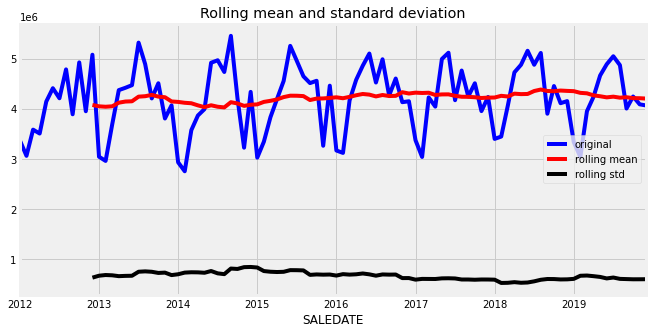

Students' criterion: p=2.226966943223651e-79
Results of Dickey-Fuller test:
Test statistics (ADF)          -1.797310
p-value                         0.381798
Number of lags used            11.000000
Number of observations used    84.000000
Critical value (1%)            -3.510712
Critical value (5%)            -2.896616
Critical value (10%)           -2.585482
dtype: float64


In [ ]:
check_time_series(df['PROPERTYHOUSENUM'][:'2019-12-31']) # 只用到 2019 年底的數據

* Student's test $p$-value < 0.05 $\rightarrow$ reject null hypothesis
* Dickey-Fuller test $p$-value > 0.05 $\rightarrow$ not reject null hypothesis (i.e. this time series is non-stationary)
    * Need to apply differencing to make the time series stationary

In [ ]:
# 用已有的函數畫圖
def plot_lags_autocorrelation_acf_pacf(time_series, nlags=50): # 只畫前 50 個 lags
  fig, ax = plt.subplots(2, 2, figsize=(18, 8))
  # 畫 lag_plot(), autocorrelation_plot()
  pd.plotting.lag_plot(time_series, ax=ax[0][0])
  pd.plotting.autocorrelation_plot(time_series, ax=ax[0][1])

  # 畫 plot_acf(), plot_pacf()
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  plot_acf(time_series, lags=nlags, ax=ax[1][0]) 
  plot_pacf(time_series, lags=nlags, ax=ax[1][1])

  plt.tight_layout()
  plt.show()

# 自己手動計算 ACF 和 PACF 然後畫圖
def plot_calculated_acf_and_pacf(time_series, nlags=50): # 只畫前 50 個 lags
  import numpy as np
  from statsmodels.tsa.stattools import acf, pacf
  lag_acf = acf(time_series, nlags=nlags)
  lag_pacf = pacf(time_series, nlags=nlags, method='ols') # OLS: ordinary least square

  fig, ax = plt.subplots(1, 2, figsize=(18, 4))
  ax[0].plot(lag_acf)
  ax[0].axhline(y=0, linestyle='--', color='gray')
  ax[0].axhline(y=-1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[0].axhline(y=1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[0].set_title('Autocorrelation Function')

  ax[1].plot(lag_pacf)
  ax[1].axhline(y=0, linestyle='--', color='gray')
  ax[1].axhline(y=-1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[1].axhline(y=1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[1].set_title('Partical Autocorrelation Function')

  plt.tight_layout()
  plt.show()

def plot_seasonal_decomposition(time_series, model): # model=additive or multiplicative
  from statsmodels.tsa.seasonal import seasonal_decompose
  decomposition = seasonal_decompose(time_series, model=model)
  # 只畫一張圖，會很小，都擠在一起
  # fig = decomposition.plot()

  # 改成單獨畫每張圖
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  fig, ax = plt.subplots(3, 1, figsize=(18, 9))
  trend.plot(ax=ax[0])
  ax[0].set_ylabel('Trend')

  seasonal.plot(ax=ax[1])
  ax[1].set_ylabel('Seasonal')

  residual.plot(ax=ax[2])
  ax[2].set_ylabel('Residual')

  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


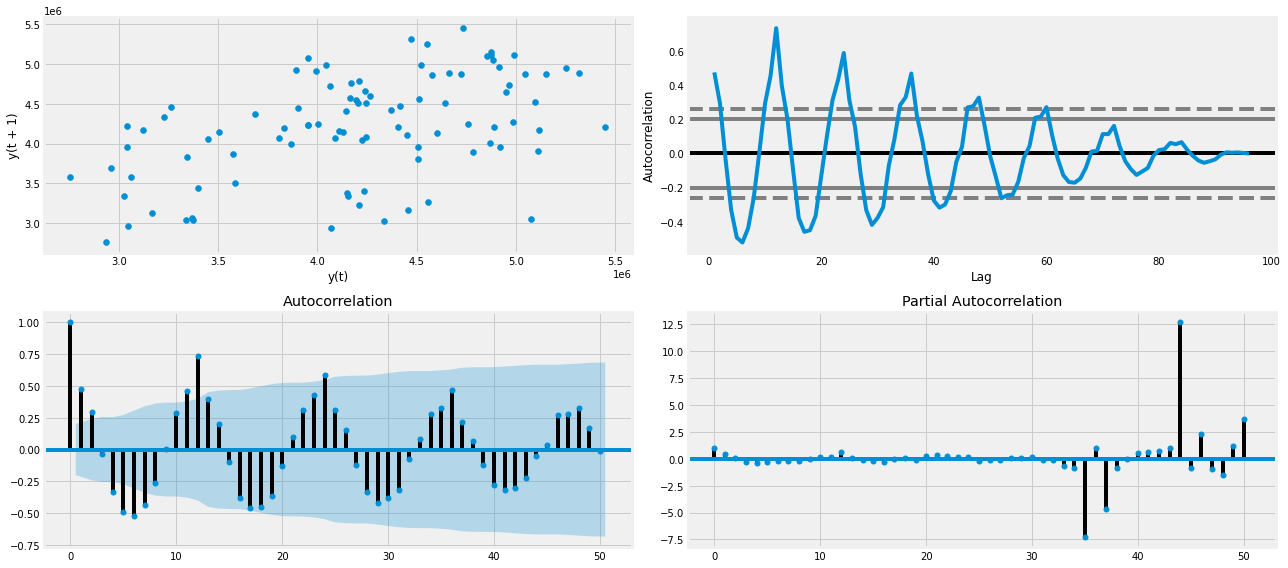

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


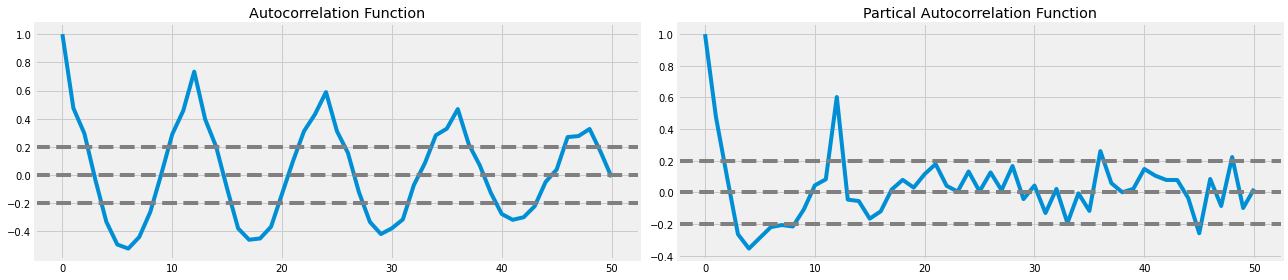

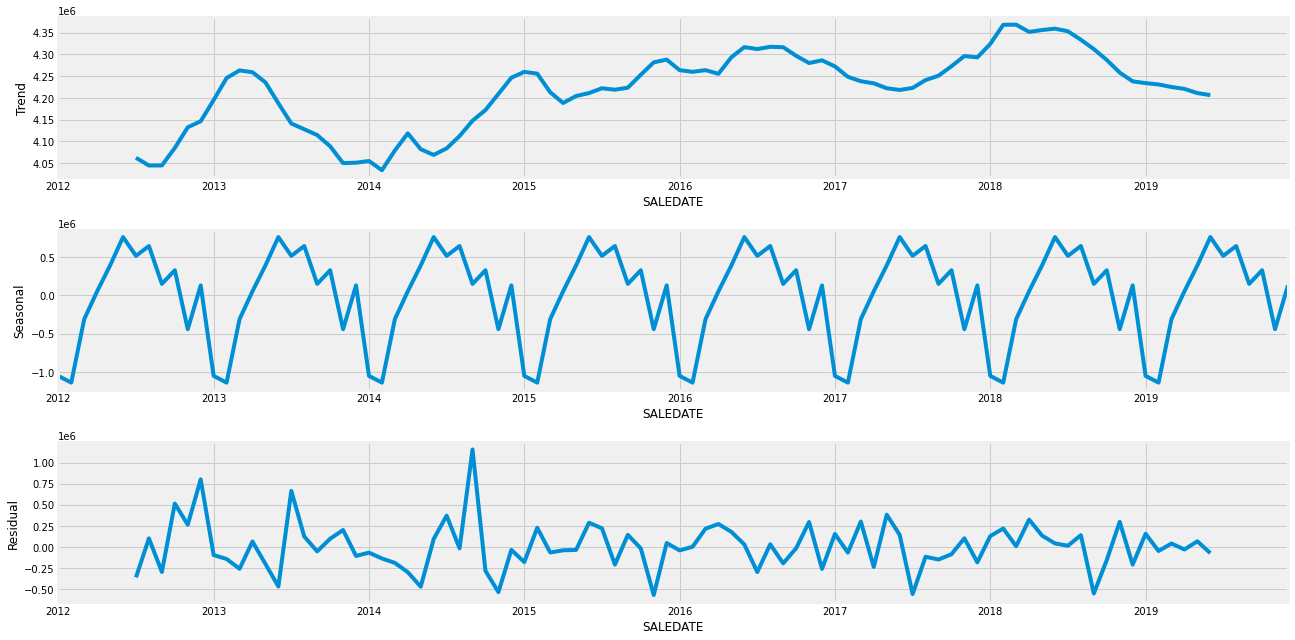

In [ ]:
plot_lags_autocorrelation_acf_pacf(df['PROPERTYHOUSENUM'][:'2019-12-31'])
plot_calculated_acf_and_pacf(df['PROPERTYHOUSENUM'][:'2019-12-31'])
plot_seasonal_decomposition(df['PROPERTYHOUSENUM'][:'2019-12-31'], model='additive')

* 有 correlation
* $p \sim 2$, $q \sim 4$
* 2019 之前都沒有什麼 trend (從 4.1 變成 4.3 有很小的 trend), 有 seasonality
    * $d \sim 1$ or $2$
    * seasonal = 12

## 3. Forecast
* Use exponential smoothing model
    * Simple Exponential Smoothing (SES)
        * SES 適用於 data 沒有很明顯的 trend 和 seasonality
        * $\hat{y}_{t+1} = \alpha y_{t} + \alpha (1-\alpha) y_{t-1} + \alpha (1-\alpha)^2 y_{t-2} + \cdots$
        * Smoothing parameter $ 0 \le \alpha \le 1$
            * $\alpha = 0$ 是 average method, $\hat{y}_{t+1}$ 等於平均值
            * $\alpha = 1$ 是 naive method, $\hat{y}_{t+1}$ 等於 $y_{t}$
    * Holt
        * 適用於 data 有 trend 時
        * Forecast equation: $\hat{y}_{t+h} = \ell_{t} + hb_{t}$
        * Level equation: $\ell_{t} = \alpha y_{t} + (1-\alpha)(\ell_{t-1} + b_{t-1})$
            * Level smoothing parameter $0 \le \alpha \le 1$
        * Trend equation: $b_{t} = \beta (\ell_{t} - \ell_{t-1}) + (1-
        \beta)b_{t-1}$
            * Trend smoothing parameter $0 \le \beta \le 1$
        * Damped trend method:
            * Damping parameter $0 \lt \phi \lt 1$
            * $\hat{y}_{t+h} = \ell_{t} + (\phi + \phi^2 + \cdots + \phi^h)b_{t}$
            * $\ell_{t} = \alpha y_{t} + (1-\alpha)(\ell_{t-1} + \phi b_{t-1})$
            * $b_{t} = \beta (\ell_{t} - \ell_{t-1}) + (1-
        \beta)\phi b_{t-1}$
    * Holt-Winters
        * 適用於 data 有 trend 和 seasonality 時
        * seasonal variation 可以是 additive 或是 multiplicative
        * seasonality smoothing parameter $\gamma$

* Models

| Model | Trend | Seasonality |
|:----|:----:|:----:|
|SES|X|X|
|Holt|V|X|
|Holt-Winter|V|V|

* Parameters

| Level | Trend | Damping | Seasonality |
|:---:|:---:|:---:|:---:|
|$\alpha$|$\beta$|$\phi$|$\gamma$|

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df.index.min(), df.index.max()

(Timestamp('2012-01-31 00:00:00', freq='M'),
 Timestamp('2020-09-30 00:00:00', freq='M'))

In [ ]:
# Use 2012 to 2018 as training sample and 2018 to 2020 as testing sample
train = df['PROPERTYHOUSENUM'][:'2017-12-31']
test = df['PROPERTYHOUSENUM']['2018-01-01':'2019-12-31']
print(len(train), train)
print(len(test), test)

72 SALEDATE
2012-01-31    3370236.0
2012-02-29    3063270.0
2012-03-31    3584459.0
2012-04-30    3506950.0
2012-05-31    4143140.0
                ...    
2017-08-31    4761062.0
2017-09-30    4245110.0
2017-10-31    4507117.0
2017-11-30    3953748.0
2017-12-31    4234143.0
Freq: M, Name: PROPERTYHOUSENUM, Length: 72, dtype: float64
24 SALEDATE
2018-01-31    3400054.0
2018-02-28    3447038.0
2018-03-31    4062001.0
2018-04-30    4724764.0
2018-05-31    4875467.0
2018-06-30    5154099.0
2018-07-31    4876045.0
2018-08-31    5110962.0
2018-09-30    3901687.0
2018-10-31    4452445.0
2018-11-30    4111201.0
2018-12-31    4152266.0
2019-01-31    3337275.0
2019-02-28    3042539.0
2019-03-31    3950811.0
2019-04-30    4238293.0
2019-05-31    4662308.0
2019-06-30    4885903.0
2019-07-31    5045254.0
2019-08-31    4868249.0
2019-09-30    4004477.0
2019-10-31    4244198.0
2019-11-30    4088341.0
2019-12-31    4065054.0
Freq: M, Name: PROPERTYHOUSENUM, dtype: float64


### 用 SES

In [ ]:
def forecasting_SES(data, params=None):
  # Use single exponential smoothing (SES) model
  model = SimpleExpSmoothing(data)

  # fit model
  model_fit = model.fit(**params)
  fitted_params = model_fit.params

  y_pred = model_fit.predict(start=0, end=len(data)-1)

  # Calculate metric
  mae = mean_absolute_error(data, y_pred)
  mse = mean_squared_error(data, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(data, y_pred)
  print(f'metrics: MAE={mae}, RMSE={rmse}, r2 score={r2}')

  return model_fit

In [ ]:
model_fit1 = forecasting_SES(train, params={'smoothing_level': 0.2, 'optimized':False})
y_hat_fit1 = model_fit1.fittedvalues
y_pred_fit1 = model_fit1.predict(start=len(train), end=len(train) + len(test) - 1)
print(y_hat_fit1)
print(y_pred_fit1)

metrics: MAE=559775.3041022393, RMSE=691448.2371348204, r2 score=-0.07796722745870399
SALEDATE
2012-01-31    3.370236e+06
2012-02-29    3.370236e+06
2012-03-31    3.308843e+06
2012-04-30    3.363966e+06
2012-05-31    3.392563e+06
                  ...     
2017-08-31    4.345005e+06
2017-09-30    4.428216e+06
2017-10-31    4.391595e+06
2017-11-30    4.414699e+06
2017-12-31    4.322509e+06
Freq: M, Length: 72, dtype: float64
2018-01-31    4.304836e+06
2018-02-28    4.304836e+06
2018-03-31    4.304836e+06
2018-04-30    4.304836e+06
2018-05-31    4.304836e+06
2018-06-30    4.304836e+06
2018-07-31    4.304836e+06
2018-08-31    4.304836e+06
2018-09-30    4.304836e+06
2018-10-31    4.304836e+06
2018-11-30    4.304836e+06
2018-12-31    4.304836e+06
2019-01-31    4.304836e+06
2019-02-28    4.304836e+06
2019-03-31    4.304836e+06
2019-04-30    4.304836e+06
2019-05-31    4.304836e+06
2019-06-30    4.304836e+06
2019-07-31    4.304836e+06
2019-08-31    4.304836e+06
2019-09-30    4.304836e+06
2019-

In [ ]:
model_fit2 = forecasting_SES(train, {'smoothing_level':0.6, 'optimized':False})
y_hat_fit2 = model_fit2.fittedvalues
y_pred_fit2 = model_fit2.predict(start=len(train), end=len(train) + len(test) - 1)
print(y_hat_fit2)
print(y_pred_fit2)

metrics: MAE=546518.6941998088, RMSE=653940.0341467926, r2 score=0.035811246645181205
SALEDATE
2012-01-31    3.370236e+06
2012-02-29    3.370236e+06
2012-03-31    3.186056e+06
2012-04-30    3.425098e+06
2012-05-31    3.474209e+06
                  ...     
2017-08-31    4.463308e+06
2017-09-30    4.641960e+06
2017-10-31    4.403850e+06
2017-11-30    4.465810e+06
2017-12-31    4.158573e+06
Freq: M, Length: 72, dtype: float64
2018-01-31    4.203915e+06
2018-02-28    4.203915e+06
2018-03-31    4.203915e+06
2018-04-30    4.203915e+06
2018-05-31    4.203915e+06
2018-06-30    4.203915e+06
2018-07-31    4.203915e+06
2018-08-31    4.203915e+06
2018-09-30    4.203915e+06
2018-10-31    4.203915e+06
2018-11-30    4.203915e+06
2018-12-31    4.203915e+06
2019-01-31    4.203915e+06
2019-02-28    4.203915e+06
2019-03-31    4.203915e+06
2019-04-30    4.203915e+06
2019-05-31    4.203915e+06
2019-06-30    4.203915e+06
2019-07-31    4.203915e+06
2019-08-31    4.203915e+06
2019-09-30    4.203915e+06
2019-

In [ ]:
model_fit3 = forecasting_SES(train, params={'optimized':True}) # automatically find an optimized value
y_hat_fit3 = model_fit3.fittedvalues
y_pred_fit3 = model_fit3.predict(start=len(train), end=len(train) + len(test) - 1)
print(y_hat_fit3)
print(y_pred_fit3)
print('alpha = ', model_fit3.model.params['smoothing_level'])

metrics: MAE=544939.6186660778, RMSE=653193.66397618, r2 score=0.03801093165483371
SALEDATE
2012-01-31    3.370236e+06
2012-02-29    3.370236e+06
2012-03-31    3.171909e+06
2012-04-30    3.438453e+06
2012-05-31    3.482708e+06
                  ...     
2017-08-31    4.445000e+06
2017-09-30    4.649204e+06
2017-10-31    4.388123e+06
2017-11-30    4.465004e+06
2017-12-31    4.134687e+06
Freq: M, Length: 72, dtype: float64
2018-01-31    4.198944e+06
2018-02-28    4.198944e+06
2018-03-31    4.198944e+06
2018-04-30    4.198944e+06
2018-05-31    4.198944e+06
2018-06-30    4.198944e+06
2018-07-31    4.198944e+06
2018-08-31    4.198944e+06
2018-09-30    4.198944e+06
2018-10-31    4.198944e+06
2018-11-30    4.198944e+06
2018-12-31    4.198944e+06
2019-01-31    4.198944e+06
2019-02-28    4.198944e+06
2019-03-31    4.198944e+06
2019-04-30    4.198944e+06
2019-05-31    4.198944e+06
2019-06-30    4.198944e+06
2019-07-31    4.198944e+06
2019-08-31    4.198944e+06
2019-09-30    4.198944e+06
2019-10-

,Actual,pred_1,pred_2,pred_3
2012-01-31,3370236.0,3370236.000,3370236.000,3.370236e+06
2012-02-29,3063270.0,3370236.000,3370236.000,3.370236e+06
2012-03-31,3584459.0,3308842.800,3186056.400,3.171909e+06
2012-04-30,3506950.0,3363966.040,3425097.960,3.438453e+06
2012-05-31,4143140.0,3392562.832,3474209.184,3.482708e+06


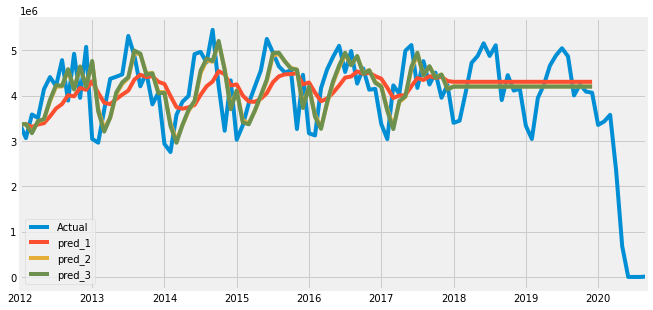

In [ ]:
pred_1 = y_hat_fit1.append(y_pred_fit1)
pred_2 = y_hat_fit2.append(y_pred_fit2)
pred_3 = y_hat_fit3.append(y_pred_fit3)

df.rename(columns={'PROPERTYHOUSENUM':'Actual'}, inplace=True)

df1 = pd.concat([df, pred_1], axis=1)
df1.rename(columns={0:'pred_1'}, inplace=True)
df1 = pd.concat([df1, pred_2], axis=1)
df1.rename(columns={0:'pred_2'}, inplace=True)
df1 = pd.concat([df1, pred_3], axis=1)
df1.rename(columns={0:'pred_3'}, inplace=True)
display(df1.head())

fig, ax = plt.subplots(figsize=(10, 5))
df1.plot(ax=ax)
plt.show()

Data 是沒有 trend 但是有 seasonality 的，所以用 SES 不能預測出 trend 和 seasonality，因此得到一條直線

### 用 Holt method

In [ ]:
def forecasting_Holt(data, exponential=False, damped=False, params=None):
  # Use single exponential smoothing (SES) model
  model = Holt(data, exponential, damped)

  # fit model
  model_fit = model.fit(**params)
  fitted_params = model_fit.params

  y_pred = model_fit.predict(start=0, end=len(data)-1)

  # Calculate metric
  mae = mean_absolute_error(data, y_pred)
  mse = mean_squared_error(data, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(data, y_pred)
  print(f'metrics: MAE={mae}, RMSE={rmse}, r2 score={r2}')

  return model_fit

In [ ]:
# additive model, no damping
model_fit1 = forecasting_Holt(train, params={'smoothing_level': 0.8, 'smoothing_slope': 0.2, 'optimized': False})
y_hat_fit1 = model_fit1.fittedvalues
y_pred_fit1 = model_fit1.predict(start=len(train), end=len(train) + len(test) - 1)
print(y_hat_fit1)
print(y_pred_fit1)

metrics: MAE=593580.788751005, RMSE=721924.9521404312, r2 score=-0.17508779526256601
SALEDATE
2012-01-31    3.063270e+06
2012-02-29    3.050991e+06
2012-03-31    2.804927e+06
2012-04-30    3.297391e+06
2012-05-31    3.367406e+06
                  ...     
2017-08-31    4.400640e+06
2017-09-30    4.756577e+06
2017-10-31    4.333168e+06
2017-11-30    4.485924e+06
2017-12-31    3.988632e+06
Freq: M, Length: 72, dtype: float64
2018-01-31    4.152771e+06
2018-02-28    4.120501e+06
2018-03-31    4.088231e+06
2018-04-30    4.055962e+06
2018-05-31    4.023692e+06
2018-06-30    3.991422e+06
2018-07-31    3.959153e+06
2018-08-31    3.926883e+06
2018-09-30    3.894613e+06
2018-10-31    3.862343e+06
2018-11-30    3.830074e+06
2018-12-31    3.797804e+06
2019-01-31    3.765534e+06
2019-02-28    3.733264e+06
2019-03-31    3.700995e+06
2019-04-30    3.668725e+06
2019-05-31    3.636455e+06
2019-06-30    3.604185e+06
2019-07-31    3.571916e+06
2019-08-31    3.539646e+06
2019-09-30    3.507376e+06
2019-1

In [ ]:
# exponential model, no damping
model_fit2 = forecasting_Holt(train, exponential=True, params={'smoothing_level': 0.8, 'smoothing_slope': 0.2, 'optimized': False})
y_hat_fit2 = model_fit2.fittedvalues
y_pred_fit2 = model_fit2.predict(start=len(train), end=len(train) + len(test) - 1)
print(y_hat_fit2)
print(y_pred_fit2)

metrics: MAE=587379.790576987, RMSE=722679.2522929906, r2 score=-0.17754464887306498
SALEDATE
2012-01-31    3.063270e+06
2012-02-29    3.055688e+06
2012-03-31    2.828626e+06
2012-04-30    3.307484e+06
2012-05-31    3.372239e+06
                  ...     
2017-08-31    4.469795e+06
2017-09-30    4.817216e+06
2017-10-31    4.380732e+06
2017-11-30    4.524425e+06
2017-12-31    4.023660e+06
Freq: M, Length: 72, dtype: float64
2018-01-31    4.181178e+06
2018-02-28    4.170339e+06
2018-03-31    4.159527e+06
2018-04-30    4.148743e+06
2018-05-31    4.137987e+06
2018-06-30    4.127260e+06
2018-07-31    4.116559e+06
2018-08-31    4.105887e+06
2018-09-30    4.095243e+06
2018-10-31    4.084626e+06
2018-11-30    4.074036e+06
2018-12-31    4.063474e+06
2019-01-31    4.052939e+06
2019-02-28    4.042432e+06
2019-03-31    4.031952e+06
2019-04-30    4.021499e+06
2019-05-31    4.011073e+06
2019-06-30    4.000674e+06
2019-07-31    3.990302e+06
2019-08-31    3.979957e+06
2019-09-30    3.969639e+06
2019-1

In [ ]:
# additive model, with damping
model_fit3 = forecasting_Holt(train, damped=True, params={'smoothing_level': 0.8, 'smoothing_slope': 0.2, 'optimized': False})
y_hat_fit3 = model_fit3.fittedvalues
y_pred_fit3 = model_fit3.predict(start=len(train), end=len(train) + len(test) - 1)
print(y_hat_fit3)
print(y_pred_fit3)

TypeError: ignored

,Actual,pred_1,pred_2
2012-01-31,3370236.0,3.063270e+06,3.063270e+06
2012-02-29,3063270.0,3.050991e+06,3.055688e+06
2012-03-31,3584459.0,2.804927e+06,2.828626e+06
2012-04-30,3506950.0,3.297391e+06,3.307484e+06
2012-05-31,4143140.0,3.367406e+06,3.372239e+06


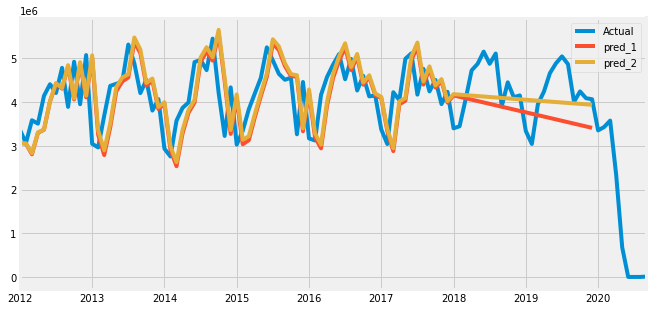

In [ ]:
pred_1 = y_hat_fit1.append(y_pred_fit1)
pred_2 = y_hat_fit2.append(y_pred_fit2)
# pred_3 = y_hat_fit3.append(y_pred_fit3)

# df.rename(columns={'PROPERTYHOUSENUM':'Actual'}, inplace=True)
df2 = pd.concat([df, pred_1], axis=1)
df2.rename(columns={0:'pred_1'}, inplace=True)
df2 = pd.concat([df2, pred_2], axis=1)
df2.rename(columns={0:'pred_2'}, inplace=True)
# df2 = pd.concat([df2, pred_3], axis=1)
# df2.rename(columns={0:'pred_3'}, inplace=True)
display(df2.head())

fig, ax = plt.subplots(figsize=(10, 5))
df2.plot(ax=ax)
plt.show()

Holt's method 可以預測出 trend 所以預測出三個不同斜率的直線

### 用 Holt-Winter method

In [ ]:
def forecasting_HoltWinter(data, model_configs, params=None):
  # Use single exponential smoothing (SES) model
  model = ExponentialSmoothing(data, **model_configs)

  # fit model
  model_fit = model.fit(**params)
  fitted_params = model_fit.params

  y_pred = model_fit.predict(start=0, end=len(data)-1)

  # Calculate metric
  mae = mean_absolute_error(data, y_pred)
  mse = mean_squared_error(data, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(data, y_pred)
  print(f'metrics: MAE={mae}, RMSE={rmse}, r2 score={r2}')

  return model_fit

In [ ]:
# additive seasonal, Box-Cox transformation
model_fit1 = forecasting_HoltWinter(train, 
                                    model_configs={'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 4}, 
                                    params={'use_boxcox':True})
y_hat_fit1 = model_fit1.fittedvalues
y_pred_fit1 = model_fit1.predict(start=len(train), end=len(train) + len(test) - 1)
print(y_hat_fit1)
print(y_pred_fit1)

metrics: MAE=548080.5178279397, RMSE=672503.2736869724, r2 score=-0.019706096209687773
SALEDATE
2012-01-31    3.643284e+06
2012-02-29    3.435540e+06
2012-03-31    3.928538e+06
2012-04-30    3.849950e+06
2012-05-31    3.691031e+06
                  ...     
2017-08-31    4.723511e+06
2017-09-30    4.537757e+06
2017-10-31    4.349065e+06
2017-11-30    4.417334e+06
2017-12-31    4.429833e+06
Freq: M, Length: 72, dtype: float64
2018-01-31    4.013869e+06
2018-02-28    4.045066e+06
2018-03-31    3.930264e+06
2018-04-30    4.294900e+06
2018-05-31    4.012347e+06
2018-06-30    4.043554e+06
2018-07-31    3.928717e+06
2018-08-31    4.293459e+06
2018-09-30    4.010826e+06
2018-10-31    4.042041e+06
2018-11-30    3.927169e+06
2018-12-31    4.292017e+06
2019-01-31    4.009303e+06
2019-02-28    4.040528e+06
2019-03-31    3.925621e+06
2019-04-30    4.290575e+06
2019-05-31    4.007780e+06
2019-06-30    4.039015e+06
2019-07-31    3.924072e+06
2019-08-31    4.289132e+06
2019-09-30    4.006257e+06
2019

In [ ]:
# multiplicative seasonal, Box-Cox transformation
model_fit2 = forecasting_HoltWinter(train, 
                                    model_configs={'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 4}, 
                                    params={'use_boxcox':True})
y_hat_fit2 = model_fit2.fittedvalues
y_pred_fit2 = model_fit2.predict(start=len(train), end=len(train) + len(test) - 1)
print(y_hat_fit2)
print(y_pred_fit2)

metrics: MAE=521965.6916731858, RMSE=627835.0705081311, r2 score=0.11125462623225113
SALEDATE
2012-01-31    2.717878e+06
2012-02-29    3.479258e+06
2012-03-31    3.179361e+06
2012-04-30    3.867923e+06
2012-05-31    3.488590e+06
                  ...     
2017-08-31    4.763845e+06
2017-09-30    4.471225e+06
2017-10-31    4.551482e+06
2017-11-30    4.354761e+06
2017-12-31    4.418393e+06
Freq: M, Length: 72, dtype: float64
2018-01-31    4.023131e+06
2018-02-28    4.243302e+06
2018-03-31    4.085043e+06
2018-04-30    4.428168e+06
2018-05-31    4.152327e+06
2018-06-30    4.377627e+06
2018-07-31    4.212542e+06
2018-08-31    4.564462e+06
2018-09-30    4.278385e+06
2018-10-31    4.508734e+06
2018-11-30    4.337027e+06
2018-12-31    4.697576e+06
2019-01-31    4.401540e+06
2019-02-28    4.636860e+06
2019-03-31    4.458717e+06
2019-04-30    4.827740e+06
2019-05-31    4.521999e+06
2019-06-30    4.762214e+06
2019-07-31    4.577808e+06
2019-08-31    4.955155e+06
2019-09-30    4.639944e+06
2019-1

In [ ]:
# additive seasonal, Box-Cox transformation, with damping
model_fit3 = forecasting_HoltWinter(train, 
                                    model_configs={'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 4, 'damped': True}, 
                                    params={'use_boxcox':True})
y_hat_fit3 = model_fit3.fittedvalues
y_pred_fit3 = model_fit3.predict(start=len(train), end=len(train) + len(test) - 1)
print(y_hat_fit3)
print(y_pred_fit3)

metrics: MAE=536384.6072132569, RMSE=652055.1240228631, r2 score=0.04136157177278266
SALEDATE
2012-01-31    3.429161e+06
2012-02-29    3.099034e+06
2012-03-31    3.597211e+06
2012-04-30    3.511380e+06
2012-05-31    3.368490e+06
                  ...     
2017-08-31    4.699242e+06
2017-09-30    4.492029e+06
2017-10-31    4.305348e+06
2017-11-30    4.456060e+06
2017-12-31    4.396483e+06
Freq: M, Length: 72, dtype: float64
2018-01-31    4.009436e+06
2018-02-28    4.002867e+06
2018-03-31    3.987730e+06
2018-04-30    4.279858e+06
2018-05-31    4.004269e+06
2018-06-30    4.001778e+06
2018-07-31    3.987500e+06
2018-08-31    4.279812e+06
2018-09-30    4.004259e+06
2018-10-31    4.001776e+06
2018-11-30    3.987500e+06
2018-12-31    4.279812e+06
2019-01-31    4.004259e+06
2019-02-28    4.001776e+06
2019-03-31    3.987500e+06
2019-04-30    4.279812e+06
2019-05-31    4.004259e+06
2019-06-30    4.001776e+06
2019-07-31    3.987500e+06
2019-08-31    4.279812e+06
2019-09-30    4.004259e+06
2019-1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [ ]:
# multiplicative seasonal, Box-Cox transformation, with damping
model_fit4 = forecasting_HoltWinter(train, 
                                    model_configs={'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 4, 'damped': True}, 
                                    params={'use_boxcox':True})
y_hat_fit4 = model_fit4.fittedvalues
y_pred_fit4 = model_fit4.predict(start=len(train), end=len(train) + len(test) - 1)
print(y_hat_fit4)
print(y_pred_fit4)

metrics: MAE=511812.55673767655, RMSE=616127.1252051264, r2 score=0.14409242802899414
SALEDATE
2012-01-31    3.223935e+06
2012-02-29    3.499779e+06
2012-03-31    3.052604e+06
2012-04-30    3.693234e+06
2012-05-31    3.313725e+06
                  ...     
2017-08-31    4.740114e+06
2017-09-30    4.398920e+06
2017-10-31    4.507269e+06
2017-11-30    4.283424e+06
2017-12-31    4.384197e+06
Freq: M, Length: 72, dtype: float64
2018-01-31    3.963882e+06
2018-02-28    4.158798e+06
2018-03-31    3.954242e+06
2018-04-30    4.270961e+06
2018-05-31    3.959533e+06
2018-06-30    4.157843e+06
2018-07-31    3.954052e+06
2018-08-31    4.270918e+06
2018-09-30    3.959525e+06
2018-10-31    4.157841e+06
2018-11-30    3.954052e+06
2018-12-31    4.270918e+06
2019-01-31    3.959525e+06
2019-02-28    4.157841e+06
2019-03-31    3.954052e+06
2019-04-30    4.270918e+06
2019-05-31    3.959525e+06
2019-06-30    4.157841e+06
2019-07-31    3.954052e+06
2019-08-31    4.270918e+06
2019-09-30    3.959525e+06
2019-

,Actual,pred_1,pred_2,pred_3,pred_4
2012-01-31,3370236.0,3.643284e+06,2.717878e+06,3.429161e+06,3.223935e+06
2012-02-29,3063270.0,3.435540e+06,3.479258e+06,3.099034e+06,3.499779e+06
2012-03-31,3584459.0,3.928538e+06,3.179361e+06,3.597211e+06,3.052604e+06
2012-04-30,3506950.0,3.849950e+06,3.867923e+06,3.511380e+06,3.693234e+06
2012-05-31,4143140.0,3.691031e+06,3.488590e+06,3.368490e+06,3.313725e+06


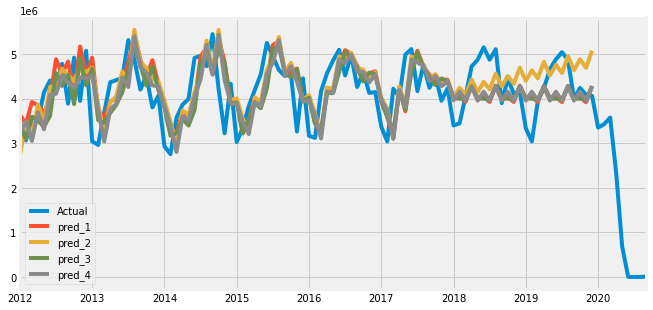

In [ ]:
pred_1 = y_hat_fit1.append(y_pred_fit1)
pred_2 = y_hat_fit2.append(y_pred_fit2)
pred_3 = y_hat_fit3.append(y_pred_fit3)
pred_4 = y_hat_fit4.append(y_pred_fit4)

# df.rename(columns={'PROPERTYHOUSENUM':'Actual'}, inplace=True)
df3 = pd.concat([df, pred_1], axis=1)
df3.rename(columns={0:'pred_1'}, inplace=True)
df3 = pd.concat([df3, pred_2], axis=1)
df3.rename(columns={0:'pred_2'}, inplace=True)
df3 = pd.concat([df3, pred_3], axis=1)
df3.rename(columns={0:'pred_3'}, inplace=True)
df3 = pd.concat([df3, pred_4], axis=1)
df3.rename(columns={0:'pred_4'}, inplace=True)
display(df3.head())

fig, ax = plt.subplots(figsize=(10, 5))
df3.plot(ax=ax)
plt.show()

Holt-Winter 可以預測出 trend 和 seasonality 所以預測的結果也有 trend 和 seasonality，只是預測的結果不準確而已

### 改用 ARIMA 做看看
* 用 auto-arima

In [ ]:
pip install pyramid-arima

     |████████████████████████████████| 604kB 3.5MB/s 


In [ ]:
from pyramid.arima import auto_arima

stepwise_model = auto_arima(train,
                            start_p=1, start_q=1, max_p=2, max_q=4,
                            start_P=1,
                            d=2, D=1,
                            m=12, # number of periods in each season
                            seasonal=True,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
print(stepwise_model.aic())
print(stepwise_model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=1707.670, BIC=1720.033, Fit time=0.965 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1774.668, BIC=1778.789, Fit time=0.019 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1750.208, BIC=1758.450, Fit time=0.233 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1714.541, BIC=1722.783, Fit time=0.230 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1704.869, BIC=1715.171, Fit time=0.690 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1707.596, BIC=1715.837, Fit time=0.246 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1700.448, BIC=1712.811, Fit time=0.422 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 1, 1, 

24 <class 'numpy.ndarray'>
[3414194.32654122 3190377.20735449 4237779.26078787 4221463.87398766
 4971581.18057805 5196797.06659867 4499585.30445422 4945051.69127222
 4514272.8853846  4731800.02210483 4156104.19143276 4541527.63218505
 3744923.76611979 3581984.35561336 4603950.63000899 4672313.34882955
 5374538.98019117 5661385.57198243 5080645.00321819 5499111.10213378
 5126420.87237448 5354990.71962274 4799086.43704457 5251712.1946685 ]
confidence interval:
 [[-2.36170003e+03  3.48715954e+03]
 [-8.00344726e-01  7.34161625e-01]
 [-3.89997998e-01  6.00406392e-01]
 [-2.22652487e+00 -8.58858891e-01]
 [-1.06711982e-01  1.22601538e+00]
 [-3.75831999e-01  1.11085724e+00]
 [-1.44973880e+00  1.11018798e-01]
 [ 2.68833337e+11  2.68833337e+11]]


,Prediction
SALEDATE,
2018-01-31,3.414194e+06
2018-02-28,3.190377e+06
2018-03-31,4.237779e+06
2018-04-30,4.221464e+06
2018-05-31,4.971581e+06


,PROPERTYHOUSENUM,Prediction
SALEDATE,,
2018-01-31,3400054.0,3.414194e+06
2018-02-28,3447038.0,3.190377e+06
2018-03-31,4062001.0,4.237779e+06
2018-04-30,4724764.0,4.221464e+06
2018-05-31,4875467.0,4.971581e+06


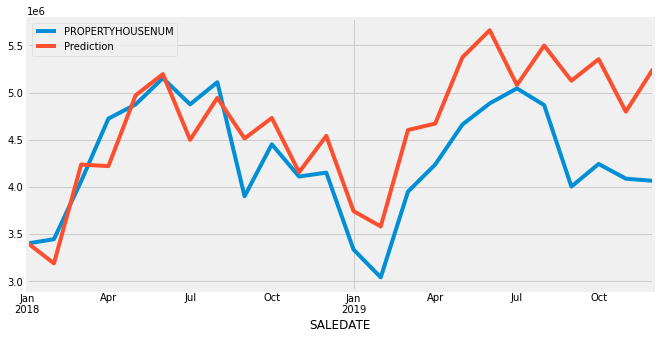

,Actual,Prediction
SALEDATE,,
2012-01-31,3370236.0,NaN
2012-02-29,3063270.0,NaN
2012-03-31,3584459.0,NaN
2012-04-30,3506950.0,NaN
2012-05-31,4143140.0,NaN
...,...,...
2020-05-31,678708.0,NaN
2020-06-30,0.0,NaN
2020-07-31,0.0,NaN


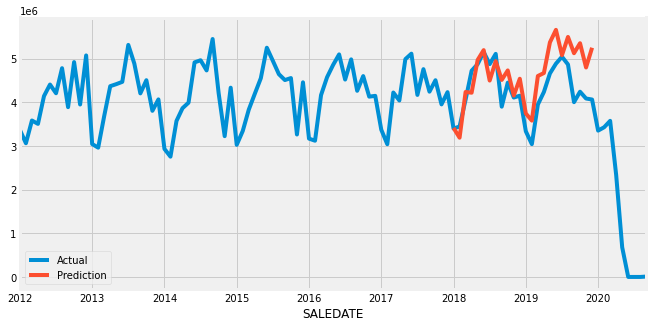

In [ ]:
stepwise_model.fit(train)

future_forecast = stepwise_model.predict(n_periods=len(test))
print(len(future_forecast), type(future_forecast))
print(future_forecast)

# confidence interval of fitted coefficients
pred_ci = stepwise_model.conf_int()
print('confidence interval:\n', pred_ci)

# 轉成 dataframe
df_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Prediction'])
display(df_forecast.head())

df_merged = pd.concat([test, df_forecast], axis=1)
display(df_merged.head())

fig, ax = plt.subplots(figsize=(10, 5))
df_merged.plot(ax=ax)
plt.show()

df_final = pd.concat([df['Actual'], df_forecast], axis=1)
display(df_final)
fig, ax = plt.subplots(figsize=(10, 5))
df_final.plot(ax=ax)
plt.show()